In [1]:
# Import required libraries to run the naive baseline
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
from torchvision.models import mobilenet_v3_small

c:\Users\paulp\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# Load dataframes

In [2]:
df_train = pd.read_csv("../data/listes_training/data_100K/train_100K.csv", delimiter=" ")
df_test = pd.read_csv("../data/listes_training/data_100K/test_students.csv", delimiter=" ")
pth_file = "epoch23.pth"

image_dir = "../data/crops_100K"

FileNotFoundError: [Errno 2] No such file or directory: '../data/listes_training/data_100K/train_100K.csv'

## Remove nan values

In [ ]:
df_train = df_train.dropna()
df_test = df_test.dropna()

## Split Dataframe in train and val

In [ ]:
df_val = df_train.loc[:20000].reset_index()
df_train = df_train.loc[20000:].reset_index()

In [ ]:
len(df_train), len(df_val), len(df_test)

(81341, 20001, 30507)

# Display first images

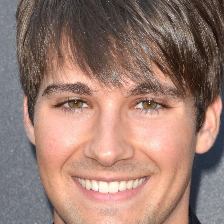

database1/img00013741.jpg 0.275 0.997


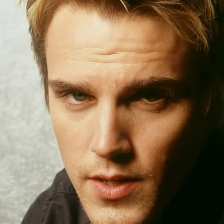

database1/img00006703.jpg 0.041 0.998


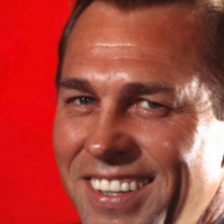

database1/img00004500.jpg 0.013 0.997


In [ ]:
for idx, row in df_train[:3].iterrows():
    filename = row['filename']
    occlusion = row['FaceOcclusion']
    gender = row['gender']
    img2display = Image.open(f"{image_dir}/{filename}")
    display(img2display)
    print(filename, occlusion, gender)

# Modeles

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, ch_in, ch_out, kernel_size):
        super().__init__()

        self.conv = nn.Conv2d(in_channels=ch_in, out_channels=ch_out, kernel_size=kernel_size)
        self.relu = nn.ReLU()
        self.bn = nn.BatchNorm2d(num_features=ch_out)
        self.maxpool = nn.MaxPool2d(kernel_size=kernel_size - 3, stride=2)

    def forward(self, x):
        x = self.conv(x)
        x = self.relu(x)
        x = self.bn(x)
        x = self.maxpool(x)
        return x
    
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = ConvBlock(3, 8, 5)
        self.conv2 = ConvBlock(8, 16, 5)
        self.conv3 = ConvBlock(16, 32, 5)
        # Adapt the feature map of the paper to our img input
        self.fc = nn.Linear(32 * 24 * 24, 1024)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        # Flatten prior to FC layer
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
class MTCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.feat_extract = ConvNet()
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 1)
        self.relu = nn.ReLU()
        self.hard_dropout = nn.Dropout(0.5)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = self.feat_extract(x)
        x = self.hard_dropout(x)

        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc3(x)

        return x

# Saliency map

In [ ]:
model = MTCNN()
model.load_state_dict(torch.load(pth_file, map_location="cpu"))
model

MTCNN(
  (feat_extract): ConvNet(
    (conv1): ConvBlock(
      (conv): Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1))
      (relu): ReLU()
      (bn): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (conv2): ConvBlock(
      (conv): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
      (relu): ReLU()
      (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (conv3): ConvBlock(
      (conv): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
      (relu): ReLU()
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (fc): Linear(in_features=18432, out_features=1024, bias=True)
  )
  (

In [ ]:
# Preprocess the image
def preprocess(image, size=224):
    transform = T.Compose([
        T.Resize((size,size)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        T.Lambda(lambda x: x[None]),
    ])
    return transform(image)

'''
    Y = (X - μ)/(σ) => Y ~ Distribution(0,1) if X ~ Distribution(μ,σ)
    => Y/(1/σ) follows Distribution(0,σ)
    => (Y/(1/σ) - (-μ))/1 is actually X and hence follows Distribution(μ,σ)
'''
def deprocess(image):
    transform = T.Compose([
        T.Lambda(lambda x: x[0]),
        T.Normalize(mean=[0, 0, 0], std=[4.3668, 4.4643, 4.4444]),
        T.Normalize(mean=[-0.485, -0.456, -0.406], std=[1, 1, 1]),
        T.ToPILImage(),
    ])
    return transform(image)

def show_img(PIL_IMG):
    plt.imshow(np.asarray(PIL_IMG))

In [ ]:
def saliency(img, score):    
    # preprocess the image
    X = preprocess(img)

    # we would run the model in evaluation mode
    model.eval()

    # we need to find the gradient with respect to the input image, so we need to call requires_grad_ on it
    X.requires_grad_()

    '''
    forward pass through the model to get the scores, note that VGG-19 model doesn't perform softmax at the end
    and we also don't need softmax, we need scores, so that's perfect for us.
    '''

    scores = model(X)

    # Get the index corresponding to the maximum score and the maximum score itself.
    score_max_index = scores.argmax()
    score_max = scores[0,score_max_index]

    '''
    backward function on score_max performs the backward pass in the computation graph and calculates the gradient of 
    score_max with respect to nodes in the computation graph
    '''
    score_max.backward()

    '''
    Saliency would be the gradient with respect to the input image now. But note that the input image has 3 channels,
    R, G and B. To derive a single class saliency value for each pixel (i, j),  we take the maximum magnitude
    across all colour channels.
    '''
    saliency, _ = torch.max(X.grad.data.abs(),dim=1)

    # code to plot the saliency map as a heatmap
    plt.subplot(1, 2, 1)
    plt.imshow(saliency[0], cmap=plt.cm.hot)
    plt.axis('off')


    # display the original image on the side
    plt.subplot(1, 2, 2)
    plt.title(score)
    plt.axis('off')
    plt.imshow(img)


# Results

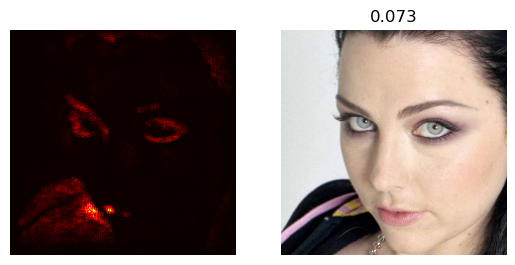

In [ ]:
# a modifier
idx = 42

row = df_train.iloc[idx]
filename = row['filename']
occlusion = row['FaceOcclusion']
gender = row['gender']
img = Image.open(f"Data_Challenge_05_2024/crops_100K/{filename}")
saliency(img, occlusion)
